# Compute correlations in longitude bins with no regime averaging

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45317,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:43297,Total threads: 4
Dashboard: /proxy/39137/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:39701,


## Load u_along and CSHT if you want to compute correlations from scratch:
Note if these are already calculated, there is section below that opens the already saved correlations and analyses them.

In [3]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho_3deg/Binned_Antarctic_slope_contour_1km_velocities*')

# resample monthly:
u_along_da_months = u_along.resample(time='1M').mean().U_along_contour_binned
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42)).rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

In [4]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')

# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()

# find longitude and density sum of unbinned CSHT for normalising the binned CSHT:
unbinned_CSHT = CSHT_along.unbinned_heat_transp_across_contour.sum('potrho0').mean('time')
unbinned_CSHT_net = unbinned_CSHT.sum('contour_index')
unbinned_CSHT_net.load()

binned_CSHT = CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence
binned_CSHT_net = binned_CSHT.sum('potrho0').sum('lon_bin_midpoints').mean('time').load()

# multiply binned CSHT by this scaling factor, so it has the same net value as the unbinned CSHT:
scaling_factor = unbinned_CSHT_net/binned_CSHT_net

# rename lon so can multiply by clustering_mask:
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans + CSHT_along_monthly.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})

# also remove unused lower 2 density bins
CSHT_months_masked = (CSHT_months.sel(potrho0=slice(13.8,28.42)))

### Choose what longitude bin size for correlations:

In [5]:
lon_bin=10
# defined 'bin_edges'
#bin_edges = np.arange(u_along_da_months.lon[0], u_along_da_months.lon[-1], lon_bin)
bin_edges = np.linspace(u_along_da_months.lon[0], u_along_da_months.lon[-1],36)

# Group longitudes into bins
u_along_da_months_binned = u_along_da_months.groupby_bins('lon', bins=bin_edges).mean()
u_along_da_months_binned.load();

# Group longitudes into 5-degree bins
# NOTE: I changed this to SUM not MEAN!!!
CSHT_months_binned = CSHT_months_masked.groupby_bins('lon', bins=bin_edges).sum()

CSHT_months_binned.load();

### Do different time averaging to compute correlations on different time scales:

In [6]:
## Average over different time scales to get depth-based correlations

CSHT_annual_binned = CSHT_months_binned.groupby('time.year').mean('time')
U_along_annual_binned = u_along_da_months_binned.groupby('time.year').mean('time')

CSHT_layerwise_binned = CSHT_months_binned
U_along_layerwise_binned = u_along_da_months_binned

In [7]:
########
# NOTE: This computes seasonality by averaging across day of year. That way we have 366 data points so correlation will be more meaningful.

u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho_3deg/Binned_Antarctic_slope_contour_1km_velocities*')

u_along_da_clima = (u_along.U_along_contour_binned).sel(potrho0=slice(13.8,28.42)).rename({'lon_bin_midpoints': 'lon'})
U_along_clima_binned = u_along_da_clima.groupby('time.dayofyear').mean('time')
# apply 20 day rolling mean to only focus on seasonality not high frequency:
U_along_clima_binned = U_along_clima_binned.rolling(dayofyear=20,center=True,min_periods=1).mean()
# group  into long bins:
U_along_clima_binned = U_along_clima_binned.groupby_bins('lon', bins=bin_edges).mean()
U_along_clima_binned.load();

CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_clima = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})
CSHT_clima_binned = CSHT_clima.sel(potrho0=slice(13.8,28.42)).groupby('time.dayofyear').mean('time')
# apply 20 day rolling mean to only focus on seasonality not high frequency:
CSHT_clima_binned = CSHT_clima_binned.rolling(dayofyear=20,center=True,min_periods=1).mean()
CSHT_clima_binned = CSHT_clima_binned.groupby_bins('lon', bins=bin_edges).sum().load()

In [8]:
#### Also try doing high frequency correlations. Substract low frequency signal somehow.

# Note: This currently doesn't work well with fixed density definitions, because layers don't exist for some longitudes and some times, so we can't compute correlations.
average_time = 60

u_along_daily = (u_along.U_along_contour_binned).sel(potrho0=slice(13.8,27.82)).rename({'lon_bin_midpoints': 'lon'})
# group  into long bins:
U_along_binned = u_along_daily.groupby_bins('lon', bins=bin_edges).mean()
# substract 30 day rolling mean:
U_along_daily_binned = U_along_binned - U_along_binned.rolling(time=average_time,center=True,min_periods=1).mean()
U_along_daily_binned = U_along_daily_binned.load()

CSHT_daily = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})
CSHT_binned = (CSHT_daily.fillna(0)).sel(potrho0=slice(13.8,27.82)).groupby_bins('lon', bins=bin_edges).sum()
# substract 30 day rolling mean:
CSHT_daily_binned = CSHT_binned - CSHT_binned.rolling(time=average_time,center=True,min_periods=1).mean()
CSHT_daily_binned = CSHT_daily_binned.load()

### Now compute the correlations:

In [9]:
#### calculating correlations for binned along-slope velocies/CSHT
files_path = '/g/data/g40/akm157/model_data/access-om2/01deg_jra55v140_iaf_cycle3/ASC_CSHT_correlations/'

# --- Save CSHT and U_along for maps of correlation and variance:

# get the latest lon interval value to build mid-point array:
lon_bin_mid = bin_edges[:-1] + np.diff(bin_edges)/2.

# first convert do xarray dataset:
coordinatesBin=dict(time=(['time'], CSHT_layerwise_binned.time.data),
        potrho0=(['potrho0'],CSHT_layerwise_binned.potrho0.data), lon_bins=(['lon_bins'], lon_bin_mid))
CSHT_layerwise_binned_xr = xr.DataArray(CSHT_layerwise_binned, coords = coordinatesBin, dims = ['time','potrho0','lon_bins'])

# rename vars:
CSHT_layerwise_binned_xr.name = 'CSHT_layerwise_binned'

CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_10degBins_NoRegimes.nc.nc', mode='w', format="NETCDF4")

# firstly, convert do xarray dataset:
u_along_da_months_binned_xr = xr.DataArray(u_along_da_months_binned, coords = coordinatesBin, dims = ['time','potrho0','lon_bins'])

# rename vars:
u_along_da_months_binned_xr.name = 'u_along_da_months_binned'

u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")


In [11]:
%%time

# Calculate the regression slope and r^2 for these longitude bins,
# [loop on i(lon_bins) and j(v-levs)]

len_lonbin = len(lon_bin_mid) # 10deg bins

slope_all = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))
stderr_all = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))
r_sq_all = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))
slope_annual = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))
stderr_annual = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))
r_sq_annual = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))

slope_clima = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))
stderr_clima = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))
r_sq_clima = np.zeros((u_along_da_months_binned.potrho0.size, len_lonbin))

slope_daily = np.zeros((u_along_da_months_binned.potrho0.size-1, len_lonbin))
stderr_daily = np.zeros((u_along_da_months_binned.potrho0.size-1, len_lonbin))
r_sq_daily = np.zeros((u_along_da_months_binned.potrho0.size-1, len_lonbin))

for i in range(len_lonbin):
    for j in range(u_along_da_months_binned.potrho0.size):
        slope_all[j,i] = stats.linregress(U_along_layerwise_binned[:,j,i], CSHT_layerwise_binned[:,j,i]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise_binned[:,j,i], CSHT_layerwise_binned[:,j,i]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise_binned[:,j,i], CSHT_layerwise_binned[:,j,i]/1e12).rvalue**2
    
        slope_annual[j,i] = stats.linregress(U_along_annual_binned[:,j,i], CSHT_annual_binned[:,j,i]/1e12).slope
        stderr_annual[j,i] = stats.linregress(U_along_annual_binned[:,j,i], CSHT_annual_binned[:,j,i]/1e12).stderr
        r_sq_annual[j,i,] = stats.linregress(U_along_annual_binned[:,j,i], CSHT_annual_binned[:,j,i]/1e12).rvalue**2

        slope_clima[j,i] = stats.linregress(U_along_clima_binned[:,j,i], CSHT_clima_binned[:,j,i]/1e12).slope
        stderr_clima[j,i] = stats.linregress(U_along_clima_binned[:,j,i], CSHT_clima_binned[:,j,i]/1e12).stderr
        r_sq_clima[j,i] = stats.linregress(U_along_clima_binned[:,j,i], CSHT_clima_binned[:,j,i]/1e12).rvalue**2

        if j < u_along_da_months_binned.potrho0.size -1:
            # for daily need for j in range(u_along_da_months_binned.potrho0.size -1):
            slope_daily[j,i] = stats.linregress(U_along_daily_binned[:,j,i], CSHT_daily_binned[:,j,i]/1e12).slope
            stderr_daily[j,i] = stats.linregress(U_along_daily_binned[:,j,i], CSHT_daily_binned[:,j,i]/1e12).stderr
            r_sq_daily[j,i] = stats.linregress(U_along_daily_binned[:,j,i], CSHT_daily_binned[:,j,i]/1e12).rvalue**2


CPU times: user 4.66 s, sys: 221 ms, total: 4.88 s
Wall time: 4.55 s


In [12]:
#### save r_sq for each time-frequency for specific long. bins:

# first convert do xarray dataset:

coordinatesBin=dict(potrho0=(['potrho0'],CSHT_layerwise_binned.potrho0.data), lon_bins=(['lon_bin_mid'], lon_bin_mid))

slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])

stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])

r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])

coordinatesBin=dict(potrho0=(['potrho0'],CSHT_layerwise_binned.potrho0.data[:-1]), lon_bins=(['lon_bin_mid'], lon_bin_mid))
slope_daily_xr = xr.DataArray(slope_daily, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
stderr_daily_xr = xr.DataArray(stderr_daily, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])
r_sq_daily_xr = xr.DataArray(r_sq_daily, coords = coordinatesBin, dims = ['potrho0','lon_bin_mid'])

# rename vars:
slope_annual_xr.name = 'slope_annual'
slope_all_xr.name = 'slope_all'
slope_clima_xr.name = 'slope_clima'
slope_daily_xr.name = 'slope_daily'

stderr_annual_xr.name = 'stderr_annual'
stderr_all_xr.name = 'stderr_all'
stderr_clima_xr.name = 'stderr_clima'
stderr_daily_xr.name = 'stderr_daily'

r_sq_annual_xr.name = 'r_sq_annual'
r_sq_all_xr.name = 'r_sq_all'
r_sq_clima_xr.name = 'r_sq_clim'
r_sq_daily_xr.name = 'r_sq_daily'

slope_annual_xr.to_netcdf(files_path + 'slope_annual_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
slope_all_xr.to_netcdf(files_path + 'slope_all_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
slope_clima_xr.to_netcdf(files_path + 'slope_clima_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
slope_daily_xr.to_netcdf(files_path + 'slope_daily_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")

stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
stderr_all_xr.to_netcdf(files_path + 'stderr_all_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
stderr_daily_xr.to_netcdf(files_path + 'stderr_daily_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")

r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
r_sq_daily_xr.to_netcdf(files_path + 'r_sq_daily_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")


## Reopen correlations previously saved above:

In [4]:
# 10deg
files_path = '/g/data/g40/akm157/model_data/access-om2/01deg_jra55v140_iaf_cycle3/ASC_CSHT_correlations/'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_NoRegimes.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_NoRegimes.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_NoRegimes.nc')
r_sq_clima_10deg = ds.r_sq_clim
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_daily_10degBins_NoRegimes.nc')
r_sq_daily_10deg = ds.r_sq_daily
ds.close()

## Do some first quick plots to look at correlations in different layers and different time scales:

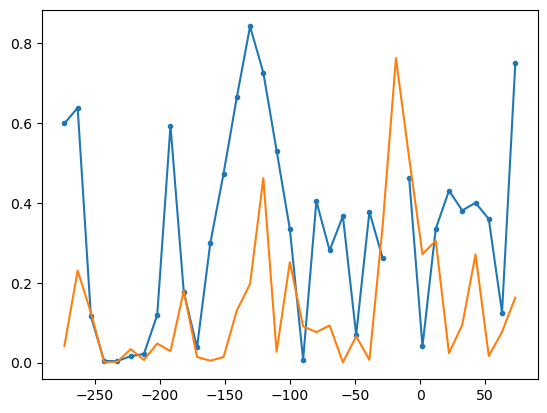

In [5]:
# Plot annual average correlations in CDW layer and layer above against longitude:

plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=27.82),'.-')
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=27.775))
#plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=27.725))
#plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=27.65))
#plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=13.8))
# I think I could infill the missing point with the density layer above.

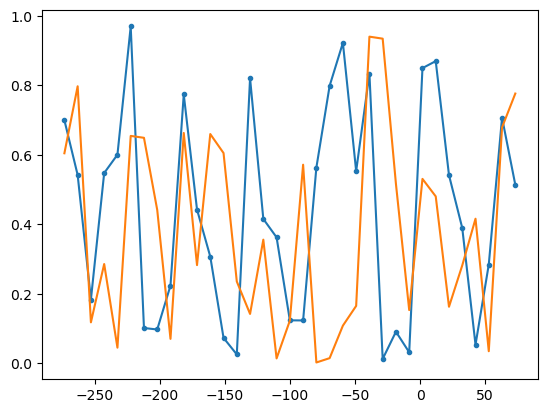

In [6]:
# Plot seasonal correlations in CDW layer and layer above against longitude:

plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg.sel(potrho0=27.82),'.-')
plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg.sel(potrho0=27.775))

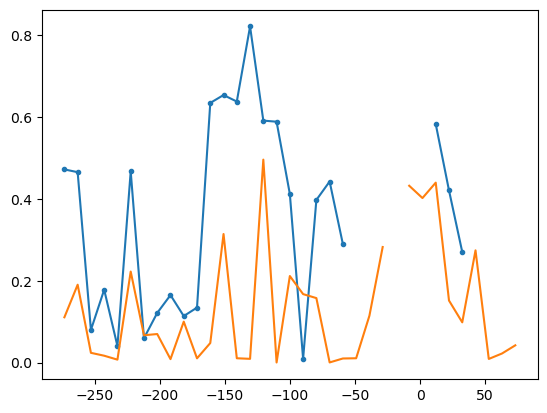

In [7]:
# Plot monthly time series correlations in CDW layer and layer above against longitude:

plt.plot(r_sq_all_10deg.lon_bins,r_sq_all_10deg.sel(potrho0=27.82),'.-')
plt.plot(r_sq_all_10deg.lon_bins,r_sq_all_10deg.sel(potrho0=27.775))

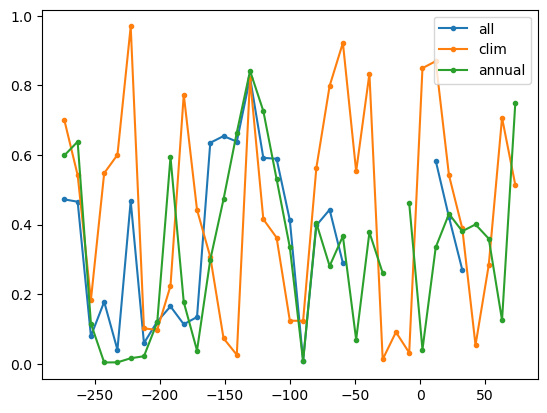

In [9]:
# Compare correlations on different time scale just in CDW layer against longitude:

plt.plot(r_sq_all_10deg.lon_bins,r_sq_all_10deg.sel(potrho0=27.82),'.-',label='all')
plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg.sel(potrho0=27.82),'.-',label='clim')
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=27.82),'.-', label='annual')
plt.legend()

### Do some plots where we replace the CDW layer in eastern Weddell with the lighter layer above:

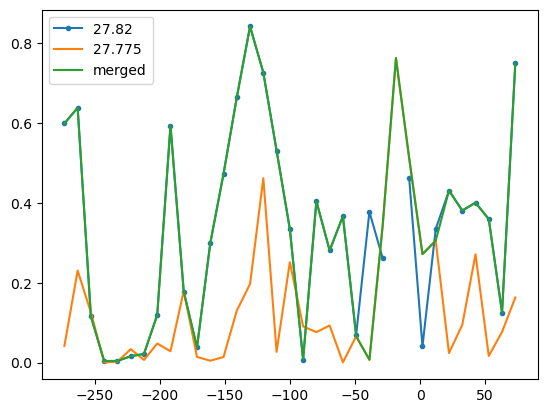

In [4]:
# Replace the 27.82 CDW layer with the lighter density layer above between ~-50 and ~10deg longitude.
# The time mean map of density in this region shows that the 27.82 layer doesn't exist at all in this longitude range.

plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=27.82),'.-',label='27.82')
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.sel(potrho0=27.775),label='27.775')

# select out CDW layer:
r_sq_annual_10deg_CDWfixed = r_sq_annual_10deg.sel(potrho0=27.82)
missing_values = np.where((r_sq_annual_10deg.lon_bins.values > -50)&(r_sq_annual_10deg.lon_bins.values < 20))
r_sq_annual_10deg_CDWfixed[missing_values] = r_sq_annual_10deg.sel(potrho0=27.775)[missing_values]
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg_CDWfixed,label='merged')
plt.legend()

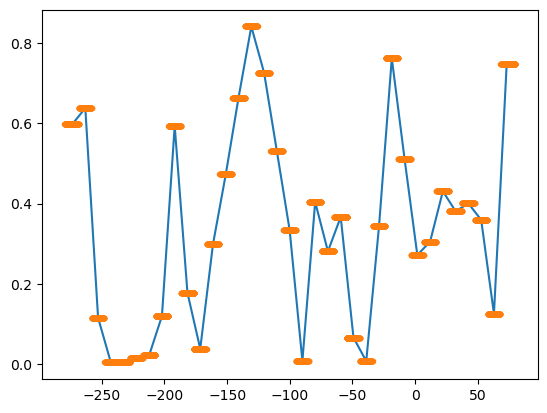

In [5]:
# interpolate longitude binned r^2 onto finer contour grid, so we can plot along contour nicely:

# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

# first fix lon dimension on r^2:
r_sq_annual_10deg_CDWfixed['lon_bin_mid'] = r_sq_annual_10deg_CDWfixed.lon_bins

# now interpolate onto lon_along_contour:
r_sq_annual_10deg_interp = r_sq_annual_10deg_CDWfixed.interp(lon_bin_mid=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg_CDWfixed,'.-')
plt.plot(r_sq_annual_10deg_interp.lon_bin_mid,r_sq_annual_10deg_interp,'.')

In [7]:
# get things ready for plotting (land mask and colormap)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# Data required for lat/lon mapping
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Plot annual correlations in CDW layer:

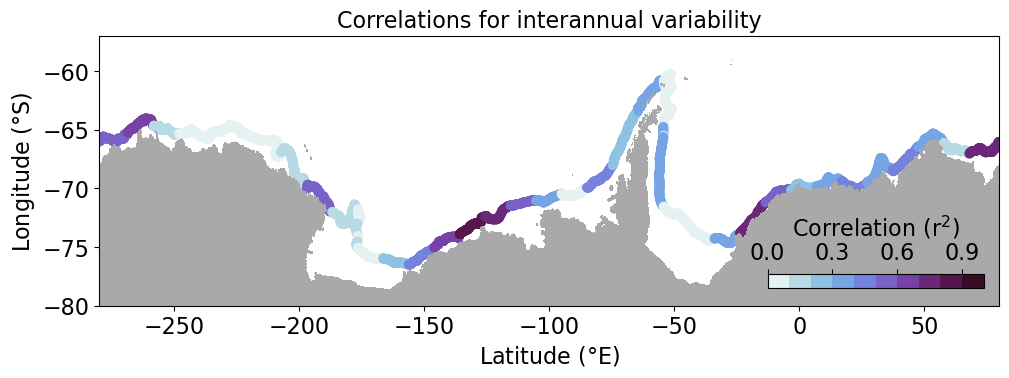

In [16]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_annual_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for interannual variability',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

### Then plot monthly climatology correlations in CDW layer:

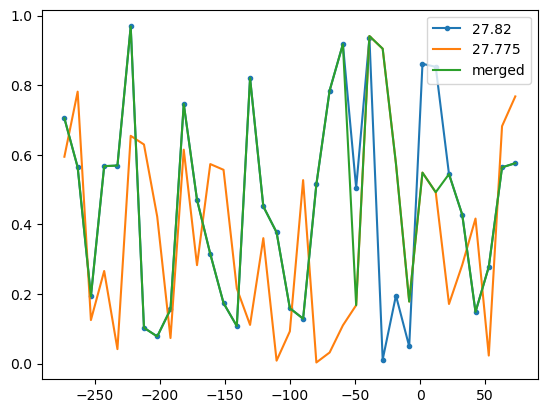

In [74]:
# Even though there are no missing longitude values for the CDW layer climatology, still replace, 
# because there is not much data/thickness in the CDW layer in eastern Weddell:
# Replace the 27.82 CDW layer with the lighter density layer above between ~-50 and ~10deg longitude.
# The time mean map of density in this region shows that the 27.82 layer doesn't exist at all in this longitude range.

plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg.sel(potrho0=27.82),'.-',label='27.82')
plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg.sel(potrho0=27.775),label='27.775')

r_sq_clima_10deg_CDWfixed = r_sq_clima_10deg.sel(potrho0=27.82)
missing_values = np.where((r_sq_clima_10deg.lon_bins.values > -50)&(r_sq_clima_10deg.lon_bins.values < 20))
r_sq_clima_10deg_CDWfixed[missing_values] = r_sq_clima_10deg.sel(potrho0=27.775)[missing_values]
plt.plot(r_sq_clima_10deg_CDWfixed.lon_bins,r_sq_clima_10deg_CDWfixed,label='merged')
plt.legend()

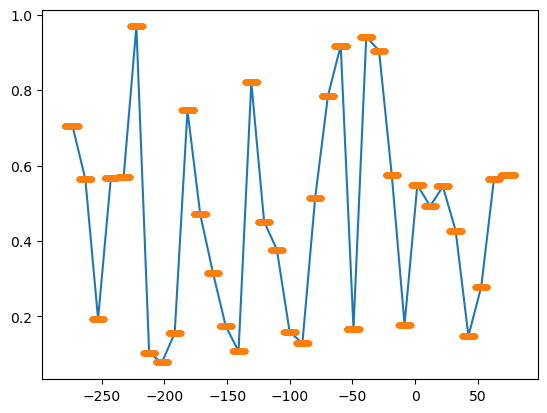

In [75]:
# interpolate longitude binned r^2 onto finer contour grid, so we can plot along contour nicely:

# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

# first fix lon dimension on r^2:
r_sq_clima_10deg_CDWfixed['lon_bin_mid'] = r_sq_clima_10deg_CDWfixed.lon_bins

# now interpolate onto lon_along_contour:
r_sq_clima_10deg_interp = r_sq_clima_10deg_CDWfixed.interp(lon_bin_mid=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg_CDWfixed,'.-')
plt.plot(r_sq_clima_10deg_interp.lon_bin_mid,r_sq_clima_10deg_interp,'.')

### Plot seasonal climatology correlations in CDW layer:

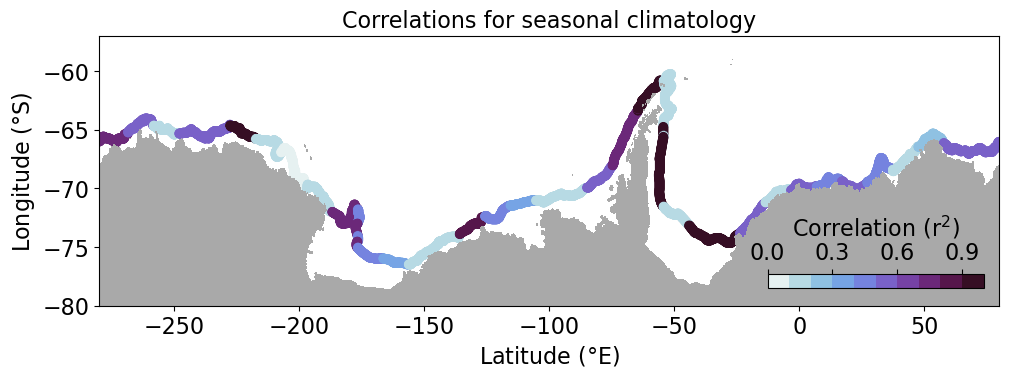

In [76]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_clima_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for seasonal climatology',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

### Then plot high frequency daily correlations in CDW layer:

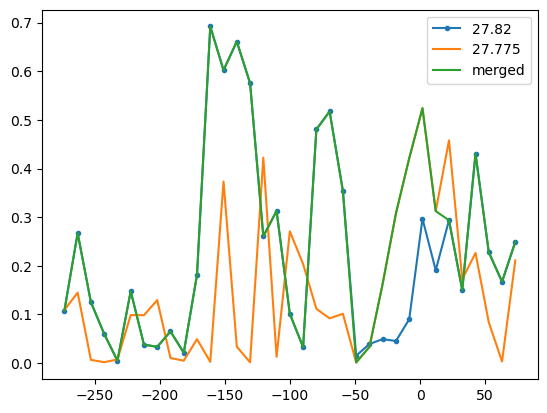

In [4]:
# Even though there are no missing longitude values for the CDW layer climatology, still replace, 
# because there is not much data/thickness in the CDW layer in eastern Weddell:
# Replace the 27.82 CDW layer with the lighter density layer above between ~-50 and ~10deg longitude.
# The time mean map of density in this region shows that the 27.82 layer doesn't exist at all in this longitude range.

plt.plot(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.sel(potrho0=27.82),'.-',label='27.82')
plt.plot(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.sel(potrho0=27.775),label='27.775')

r_sq_daily_10deg_CDWfixed = r_sq_daily_10deg.sel(potrho0=27.82)
missing_values = np.where((r_sq_daily_10deg.lon_bins.values > -50)&(r_sq_daily_10deg.lon_bins.values < 20))
r_sq_daily_10deg_CDWfixed[missing_values] = r_sq_daily_10deg.sel(potrho0=27.775)[missing_values]
plt.plot(r_sq_daily_10deg_CDWfixed.lon_bins,r_sq_daily_10deg_CDWfixed,label='merged')
plt.legend()

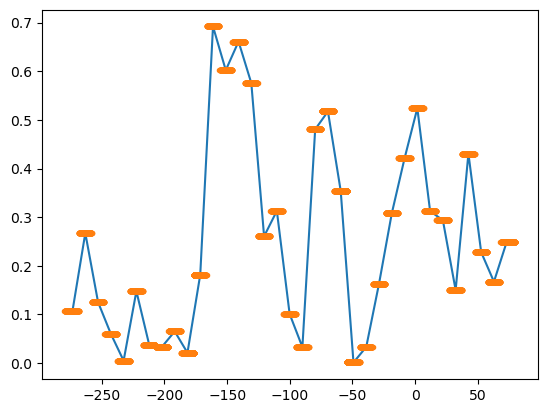

In [5]:
# interpolate longitude binned r^2 onto finer contour grid, so we can plot along contour nicely:

# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

# first fix lon dimension on r^2:
r_sq_daily_10deg_CDWfixed['lon_bin_mid'] = r_sq_daily_10deg_CDWfixed.lon_bins

# now interpolate onto lon_along_contour:
r_sq_daily_10deg_interp = r_sq_daily_10deg_CDWfixed.interp(lon_bin_mid=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_daily_10deg_CDWfixed.lon_bins,r_sq_daily_10deg_CDWfixed,'.-')
plt.plot(r_sq_daily_10deg_interp.lon_bin_mid,r_sq_daily_10deg_interp,'.')

### Plot high freq correlations in CDW layer:

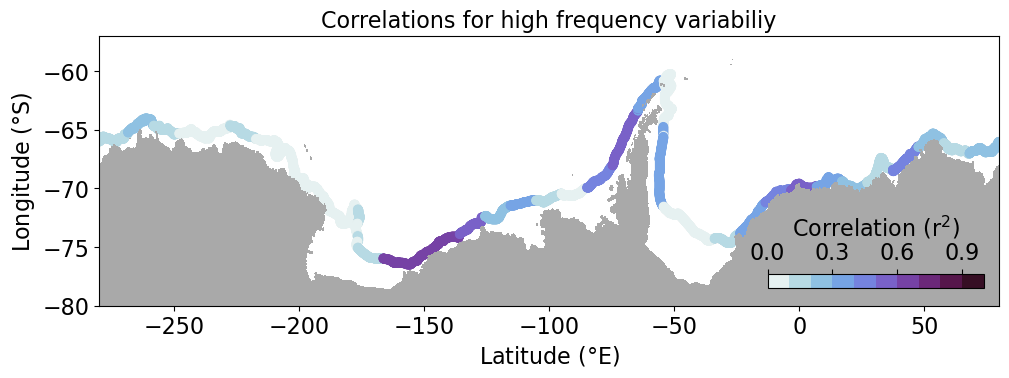

In [8]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_daily_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for high frequency variabiliy',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

In [ ]:
# to do next:
# 1. plot annual correlations with CDW layer CSHT but depth average ASC.

# can I get high frequency correlations? e.g. high pass filter. But then CDW layer won't exist a lot of the time.

